In [1]:
import pandas as pd
from pymongo import MongoClient

tf_edges = pd.read_csv(
    "data/TensorFlow/TensorFlow_edges.csv", names=["name", "dependency"]
)
pt_edges = pd.read_csv("data/PyTorch/PyTorch_edges.csv", names=["name", "dependency"])
tf_edges.head()

,name,dependency
0,hammer-sh,tensorflow
1,dlomix,tensorflow
2,artap,tensorflow
3,wikirec,tensorflow
4,hipomap,tensorflow


In [2]:
import igraph as ig
import leidenalg as la
import networkx as nx


def get_communities(framework: str, package_names: list, seed=None):
    vertices = []
    edges = []
    with open(f"data/{framework}/{framework}_edges.csv") as f:
        for line in f:
            down_pkg, up_pkg = line.strip("\n").split(",")
            has_layer1_pkg = (down_pkg in package_names) or (up_pkg in package_names)
            if not has_layer1_pkg:
                vertices.append(down_pkg)
                vertices.append(up_pkg)
                edges.append((up_pkg, down_pkg))
    vertices = list(set(vertices))
    nx_dig = nx.DiGraph()
    nx_dig.add_edges_from(edges, weight=1)
    edges = [(vertices.index(u), vertices.index(d)) for u, d in edges]
    ig_dig = ig.Graph(directed=True)
    ig_dig.add_vertices(len(vertices))
    ig_dig.add_edges(edges)
    partition = la.find_partition(
        ig_dig, la.ModularityVertexPartition, n_iterations=2, seed=seed
    )
    comm_node_centrality = []
    for par in partition:
        subg = nx_dig.subgraph([vertices[v] for v in par])
        centrality = nx.katz_centrality(subg.reverse())
        centrality = sorted(centrality.items(), key=lambda x: x[0], reverse=True)
        comm_node_centrality.append(
            sorted(centrality, key=lambda x: x[1], reverse=True)
        )

    with open(f"data/{framework}/{framework}_communities", "w") as outf:
        tmp = sorted(comm_node_centrality, key=lambda x: x[0][0].lower())
        tmp = sorted(tmp, key=lambda x: len(x), reverse=True)
        for comm in tmp:
            nodes = [v[0] for v in comm]
            outf.write(", ".join(nodes))
            outf.write("\n")
    return nx_dig, partition, comm_node_centrality

In [3]:
def comm_pkg_info(comm: list):
    info_list = []
    for pkg in comm:
        info_list.append([pkg, f"https://pypi.org/project/{pkg}/"])
    return pd.DataFrame(
        info_list,
        columns=[
            "name",
            "project_urls",
        ],
    )


def plot_communities(framework: str, package_names: list):
    comm_nodes = [
        line.strip("\n").split(", ")
        for line in open(f"data/{framework}/{framework}_communities")
    ]
    print(len(comm_nodes))

    df = pd.DataFrame()
    for i, comm in enumerate(comm_nodes):
        tmp_df = comm_pkg_info(comm)
        tmp_df.loc[:, "comm_id"] = i
        df = df.append(tmp_df)
    df.to_csv(f"data/{framework}/{framework}_community_info.csv", index=False)

    edges = []
    with open(f"data/{framework}/{framework}_edges.csv") as f:
        for line in f:
            down_pkg, up_pkg = line.strip("\n").split(",")
            has_layer1_pkg = (down_pkg in package_names) or (up_pkg in package_names)
            if not has_layer1_pkg:
                edges.append((up_pkg, down_pkg))
    nx_dig = nx.DiGraph()
    nx_dig.add_edges_from(edges, weight=1)

    for i, comm in enumerate(comm_nodes):
        subg = nx_dig.subgraph(comm)
        ig_graph = ig.Graph.from_networkx(subg)
        ig.plot(
            ig_graph,
            f"figures/{framework}/community_{i:03d}_{comm[0]}.pdf",
            vertex_size=8,
            edge_arrow_width=0.6,
            edge_arrow_size=0.6,
        )

In [4]:
plot_communities("TensorFlow", ["tensorflow", "tensorflow-cpu", "tensorflow-gpu"])

131


In [5]:
plot_communities("PyTorch", ["torch"])

100


In [2]:
import pandas as pd
tf_shapes = pd.read_excel("data/community types.xlsx", sheet_name="TensorFlow")
pt_shapes = pd.read_excel("data/community types.xlsx", sheet_name="PyTorch")
pt_shapes.head()

,Representative,Size,Inspector1,Inspector2,Final
0,torchvision,657,Tree,Tree,Tree
1,pytorch-lightning,192,Forest,Tree,Forest
2,fastai,98,Forest,Forest,Forest
3,torchaudio,96,Forest,Forest,Forest
4,torchtext,94,Forest,Forest,Forest


In [3]:
def calculate_cohen(rater1, rater2, categories):
    df = pd.DataFrame({"rater1": rater1, "rater2": rater2})
    df = (
        df.groupby(["rater1", "rater2"])
        .size()
        .reset_index(name="count")
        .pivot_table(index="rater1", columns="rater2", values="count", fill_value=0)
    )
    df = df[categories]
    df = df.reindex(categories)

    total_items = df.values.sum()
    sum1 = df.sum(axis=1)
    sum2 = df.sum(axis=0)

    p_e = sum(sum1 * sum2) / total_items**2
    p_0 = sum([df.loc[s, s] for s in categories]) / total_items

    return (p_0 - p_e) / (1 - p_e)


all_shapes = tf_shapes.append(pt_shapes, ignore_index=True)

calculate_cohen(
    all_shapes["Inspector1"],
    all_shapes["Inspector2"],
    all_shapes["Final"].unique(),
), calculate_cohen(
    tf_shapes["Inspector1"],
    tf_shapes["Inspector2"],
    tf_shapes["Final"].unique(),
), calculate_cohen(
    pt_shapes["Inspector1"],
    pt_shapes["Inspector2"],
    pt_shapes["Final"].unique(),
)

(0.9072512647554807, 0.895543545672012, 0.9183117767188563)

In [4]:
tf_shapes = tf_shapes[["Representative", "Size", "Final"]].copy()
pt_shapes = pt_shapes[["Representative", "Size", "Final"]].copy()

In [5]:
tf_shapes.groupby("Final").size().loc[["Arrow", "Star", "Tree", "Forest", "Other"]].values, pt_shapes.groupby("Final").size().loc[["Arrow", "Star", "Tree", "Forest", "Other"]]

(array([68, 26, 17, 13,  7]),
 Final
 Arrow     38
 Star      17
 Tree      20
 Forest    23
 Other      2
 dtype: int64)

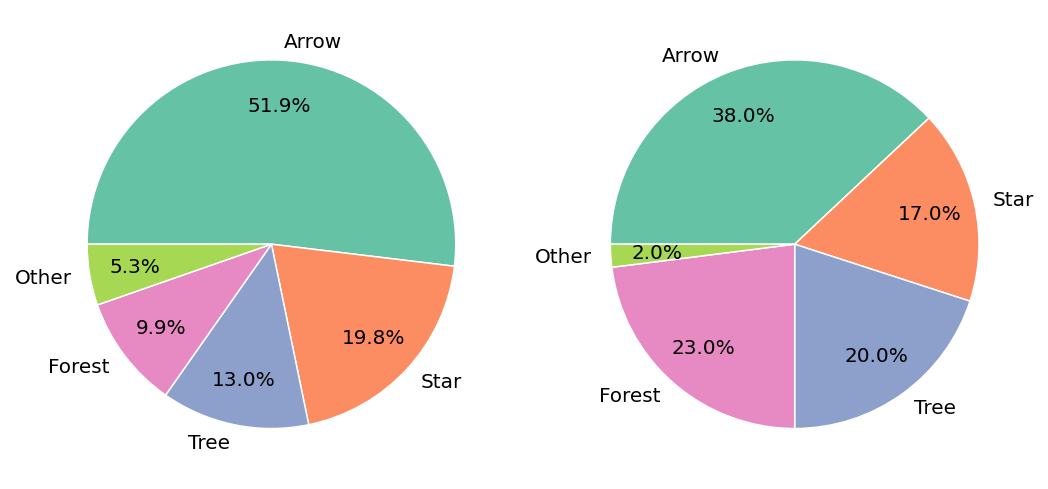

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_formats="retina"

def plot_shape_dist():
    labels = ["Arrow", "Star", "Tree", "Forest", "Other"]
    tf_data = tf_shapes.groupby("Final").size().loc[labels].values
    pt_data = pt_shapes.groupby("Final").size().loc[labels].values
    
    fig, axes = plt.subplots(1, 2, figsize=(7.5, 3.5))
    colors = sns.color_palette("Set2")

    axes[0].pie(
        tf_data, 
        colors=colors, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=-180, 
        textprops={'fontsize':10}, 
        pctdistance=0.75, 
        counterclock=False,
        wedgeprops=dict(edgecolor='w', linewidth=0.75)
    )
    axes[1].pie(
        pt_data, 
        colors=colors, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=180, 
        textprops={'fontsize':10}, 
        pctdistance=0.75, 
        counterclock=False,
        wedgeprops=dict(edgecolor='w', linewidth=0.75)
    )
    plt.tight_layout() 
    fig.savefig("figures/shape_distribution.pdf", bbox_inches="tight")
    
    return

plot_shape_dist()

In [10]:
tf_shapes.groupby("Final")["Size"].sum(), pt_shapes.groupby("Final")["Size"].sum()

(Final
 Arrow     136
 Forest    392
 Other      17
 Star      108
 Tree      239
 Name: Size, dtype: int64,
 Final
 Arrow       76
 Forest    1111
 Other        2
 Star        67
 Tree       788
 Name: Size, dtype: int64)

In [7]:
import networkx as nx

def get_clusters():
    tf_clusters = {}
    pt_clusters = {}
    with open("data/TensorFlow/TensorFlow_communities") as fin:
        for line in fin:
            edges = []
            items = line.strip("\n").split(", ")
            for row in tf_edges[
                tf_edges["name"].isin(items) & tf_edges["dependency"].isin(items)
            ].itertuples(index=False):
                edges.append((row[1], row[0]))
            G = nx.DiGraph(edges)
            tf_clusters[items[0]] = G

    with open("data/PyTorch/PyTorch_communities") as fin:
        for line in fin:
            edges = []
            items = line.strip("\n").split(", ")
            for row in pt_edges[
                pt_edges["name"].isin(items) & pt_edges["dependency"].isin(items)
            ].itertuples(index=False):
                edges.append((row[1], row[0]))
            G = nx.DiGraph(edges)
            pt_clusters[items[0]] = G

    return tf_clusters, pt_clusters


tf_clusters, pt_clusters = get_clusters()

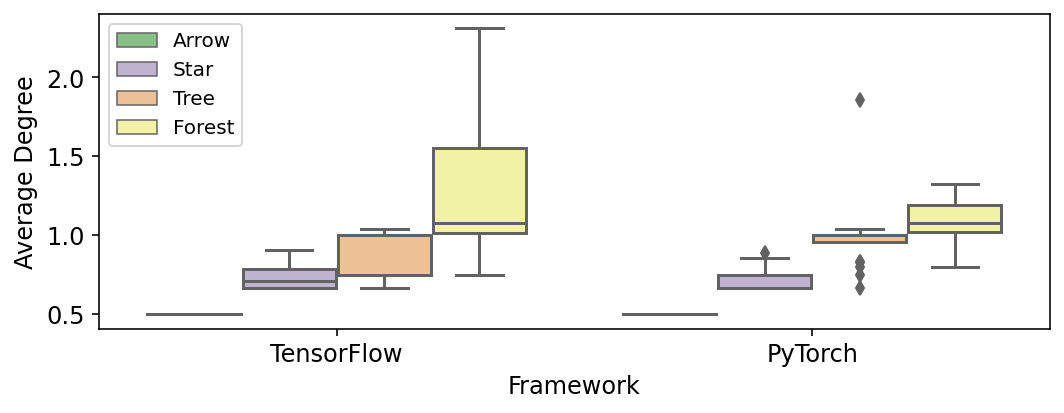

In [10]:
def tf_average_edge(s):
    g = tf_clusters[s["Representative"]]
    return len(g.edges()) / len(g.nodes())


def pt_average_edge(s):
    g = pt_clusters[s["Representative"]]
    return len(g.edges()) / len(g.nodes())


def cluster_centrality():

    tf_shapes = pd.read_excel("data/community types.xlsx", sheet_name="TensorFlow")
    pt_shapes = pd.read_excel("data/community types.xlsx", sheet_name="PyTorch")
    tf_shapes = tf_shapes[["Representative", "Size", "Final"]].copy()
    pt_shapes = pt_shapes[["Representative", "Size", "Final"]].copy()

    tf_shapes["average edge"] = tf_shapes.apply(tf_average_edge, axis=1)
    pt_shapes["average edge"] = pt_shapes.apply(pt_average_edge, axis=1)

    shapes = ["Arrow", "Star", "Tree", "Forest"]
    tf_data = (
        tf_shapes[["Final", "average edge"]].copy().rename(columns={"Final": "Shape"})
    )
    pt_data = (
        pt_shapes[["Final", "average edge"]].copy().rename(columns={"Final": "Shape"})
    )
    tf_data["Framework"] = "TensorFlow"
    pt_data["Framework"] = "PyTorch"
    data = pd.concat([tf_data, pt_data], ignore_index=True)
    fig, ax = plt.subplots(1, 1, figsize=(7.5, 3))
    palette = "Accent"
    sns.boxplot(
        x="Framework",
        y="average edge",
        data=data,
        hue="Shape",
        hue_order=shapes,
        order=["TensorFlow", "PyTorch"],
        ax=ax,
        palette=palette,
    )
    ax.tick_params(axis="both", which="major", labelsize=12)
    ax.set_xlabel("Framework", fontsize=12)
    ax.set_ylabel("Average Degree", fontsize=12)
    sns.move_legend(ax, loc="center", ncol=2, fontsize=12, bbox_to_anchor=(0.65, 0.7))
    ax.legend(loc="upper left")
    plt.tight_layout()
    fig.savefig("figures/cluster_centralities.pdf", bbox_inches="tight")
    return


cluster_centrality()

In [14]:
from multipy.fwer import holm_bonferroni
from scipy.stats import mannwhitneyu


def test_size(field):

    ps = []
    _, p1 = mannwhitneyu(
        tf_shapes[tf_shapes["Final"] == "Arrow"][field],
        tf_shapes[tf_shapes["Final"] == "Star"][field],
        alternative="less",
    )
    _, p2 = mannwhitneyu(
        tf_shapes[tf_shapes["Final"] == "Star"][field],
        tf_shapes[tf_shapes["Final"] == "Tree"][field],
        alternative="less",
    )
    _, p3 = mannwhitneyu(
        tf_shapes[tf_shapes["Final"] == "Tree"][field],
        tf_shapes[tf_shapes["Final"] == "Forest"][field],
        alternative="less",
    )
    _, p4 = mannwhitneyu(
        pt_shapes[pt_shapes["Final"] == "Arrow"][field],
        pt_shapes[pt_shapes["Final"] == "Star"][field],
        alternative="less",
    )
    _, p5 = mannwhitneyu(
        pt_shapes[pt_shapes["Final"] == "Star"][field],
        pt_shapes[pt_shapes["Final"] == "Tree"][field],
        alternative="less",
    )
    _, p6 = mannwhitneyu(
        pt_shapes[pt_shapes["Final"] == "Tree"][field],
        pt_shapes[pt_shapes["Final"] == "Forest"][field],
        alternative="less",
    )

    [a1, a2, a3, a4, a5, a6] = holm_bonferroni([p1, p2, p3, p4, p5, p6], alpha=0.05)
    ps = {
        "tf:Arrow<Star": (p1 * 6, a1),
        "tf:Star<Tree": (p2 * 2, a2),
        "tf:Tree<Forest": (p3 * 3, a3),
        "pt:Arrow<Star": (p4 * 5, a4),
        "pt:Star<Tree": (p5 * 1, a5),
        "pt:Tree<Forest": (p6 * 4, a6),
    }
    return ps


test_size("Size")

{'tf:Arrow<Star': (6.5737977526055895e-21, True),
 'tf:Star<Tree': (0.18772182434008544, False),
 'tf:Tree<Forest': (0.008809046964535504, True),
 'pt:Arrow<Star': (1.320724709469907e-12, True),
 'pt:Star<Tree': (0.11225986379211311, False),
 'pt:Tree<Forest': (0.00014025086628263644, True)}

In [15]:
tf_shapes = pd.read_excel("data/community types.xlsx", sheet_name="TensorFlow")
pt_shapes = pd.read_excel("data/community types.xlsx", sheet_name="PyTorch")
tf_shapes = tf_shapes[["Representative", "Size", "Final"]].copy()
pt_shapes = pt_shapes[["Representative", "Size", "Final"]].copy()

tf_shapes["average edge"] = tf_shapes.apply(tf_average_edge, axis=1)
pt_shapes["average edge"] = pt_shapes.apply(pt_average_edge, axis=1)
test_size("average edge")

{'tf:Arrow<Star': (6.5737977526055895e-21, True),
 'tf:Star<Tree': (0.0009716236951929591, True),
 'tf:Tree<Forest': (0.0009901758186295724, True),
 'pt:Arrow<Star': (1.320724709469907e-12, True),
 'pt:Star<Tree': (2.1451227267292412e-06, True),
 'pt:Tree<Forest': (0.0013643209467375651, True)}

In [16]:
len(pt_shapes[pt_shapes["Final"] == "Forest"]), len(
    pt_shapes[(pt_shapes["Final"] == "Forest") & (pt_shapes["average edge"] >= 1)]
), len(tf_shapes[tf_shapes["Final"] == "Forest"]), len(
    tf_shapes[(tf_shapes["Final"] == "Forest") & (tf_shapes["average edge"] >= 1)]
)

(23, 20, 13, 11)

In [17]:
len(pt_shapes[pt_shapes["Final"] == "Tree"]), len(
    pt_shapes[(pt_shapes["Final"] == "Tree") & (pt_shapes["average edge"] >= 1)]
), len(tf_shapes[tf_shapes["Final"] == "Tree"]), len(
    tf_shapes[(tf_shapes["Final"] == "Tree") & (tf_shapes["average edge"] >= 1)]
)

(20, 15, 17, 9)

In [18]:
pt_shapes.groupby("Final")["average edge"].median()

Final
Arrow     0.500000
Forest    1.080000
Other     1.000000
Star      0.666667
Tree      1.000000
Name: average edge, dtype: float64

In [19]:
tf_shapes.groupby("Final")["average edge"].median()

Final
Arrow     0.500000
Forest    1.076923
Other     0.833333
Star      0.708333
Tree      1.000000
Name: average edge, dtype: float64